In [15]:
import torch
import torchvision
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class LEVIRCDDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, label_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir_A)
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name_A = os.path.join(self.image_dir_A, self.image_filenames[idx])
        img_name_B = os.path.join(self.image_dir_B, self.image_filenames[idx])
        label_name = os.path.join(self.label_dir, self.image_filenames[idx])
        
        image_A = Image.open(img_name_A).convert("RGB")
        image_B = Image.open(img_name_B).convert("RGB")
        label = Image.open(label_name).convert("L") 
        
        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            label = self.transform(label)
        
        return (image_A, image_B), label
    
def show_images(image_A, image_B, label):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image_A.permute(1, 2, 0))
    ax[0].set_title("Image A (Before)")
    ax[1].imshow(image_B.permute(1, 2, 0))
    ax[1].set_title("Image B (After)")
    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].set_title("Change Mask")
    plt.show()

##### Train data

In [18]:
#train data
image_dir_A_train = '../data/lesson_1/train/A/'
image_dir_B_train = '../data/lesson_1/train/B/'
label_dir_train = '../data/lesson_1/train/label/'

#validation data
image_dir_A_val = '../data/lesson_1/val/A/'
image_dir_B_val = '../data/lesson_1/val/B/'
label_dir_val = '../data/lesson_1/val/label/'

#test data
image_dir_A_test = '../data/lesson_1/test/A/'
image_dir_B_test = '../data/lesson_1/test/B/'
label_dir_test = '../data/lesson_1/test/label/'


In [4]:
#defining the transformation 
#expreimentation block
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
traindataloader = DataLoader(levir_cd_dataset_train, batch_size=8, shuffle=True)

In [12]:
(image_A, image_B), label = next(iter(traindataloader))

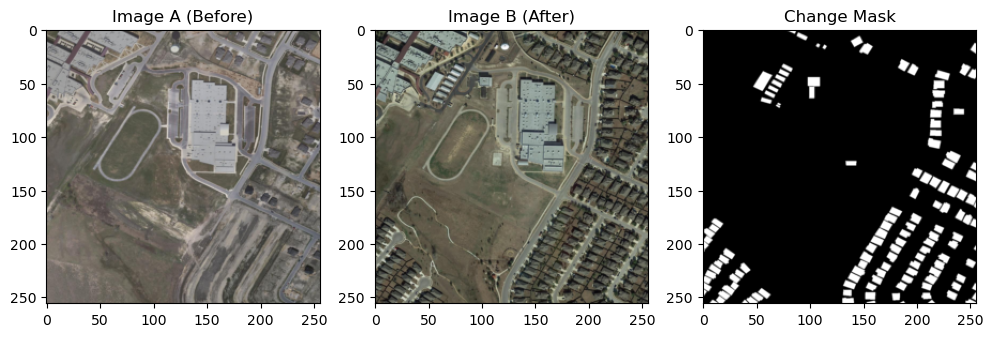

In [13]:
show_images(image_A[0], image_B[0], label[0])

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)
        
        self.up4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        return torch.sigmoid(self.final_conv(dec1))



In [29]:
# Instantiate the model
model = UNet(in_channels=6, out_channels=1)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
levir_cd_dataset_val = LEVIRCDDataset(image_dir_A_val, image_dir_B_val, label_dir_val, transform=transform)
levir_cd_dataset_test = LEVIRCDDataset(image_dir_A_test, image_dir_B_test, label_dir_test, transform=transform)


# DataLoader (assuming you've already created the DataLoader as discussed previously)
train_loader = DataLoader(levir_cd_dataset_train, batch_size=16, shuffle=True, num_workers=4)
validate_loader = DataLoader(levir_cd_dataset_val, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=16, shuffle=False, num_workers=4)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    model = model.to(device)
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for (image_A, image_B), labels in train_loader:
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            inputs = torch.cat([image_A, image_B], dim=1)  # Concatenate along the channel dimension
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        if epoch % 5 == 0:
            loss, iou, dice = validate_model(model, val_loader)
            print("-"*10)
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss:.4f}, IoU: {iou:.4f}, DICE: {dice:.4f}')

            
            if iou > best_iou:
                best_iou = iou
                print('Saving the best model with IoU:', best_iou)
                torch.save(model.state_dict(), '../data/lesson_1/model_weights/unet_best_model.pth')
        
    print('Finished Training')

def validate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for (image_A, image_B), labels in val_loader:
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            # Convert predictions to binary mask
            outputs = (outputs > 0.5).float()
            
            # Calculate IoU for each image in the batch
            intersection = (outputs * labels).sum(dim=[1, 2, 3])
            union = (outputs + labels).sum(dim=[1, 2, 3]) - intersection
            iou = intersection / (union + 1e-6)

            #DICE 
            dice = (2. * intersection) / (union + intersection + 1e-6)

            
            # Accumulate IoU and sample count
            total_iou += iou.sum().item()
            total_samples += labels.size(0)
            total_dice += dice.sum().item()

    
    epoch_loss = running_loss / len(val_loader.dataset)
    mean_iou = total_iou / total_samples
    mean_dice = total_dice / total_samples
    return epoch_loss, mean_iou, mean_dice


In [30]:
train_model(model, criterion, optimizer, train_loader, validate_loader, num_epochs=50)

Epoch 1/50, Training Loss: 0.3455
----------
Epoch 1/50, Validation Loss: 0.2137, IoU: 0.0015, DICE: 0.0030
Saving the best model with IoU: 0.0014931773075659294
Epoch 2/50, Training Loss: 0.1763
Epoch 3/50, Training Loss: 0.1229
Epoch 4/50, Training Loss: 0.0995
Epoch 5/50, Training Loss: 0.0858
Epoch 6/50, Training Loss: 0.0807
----------
Epoch 6/50, Validation Loss: 0.0753, IoU: 0.3759, DICE: 0.4932
Saving the best model with IoU: 0.3758791461586952
Epoch 7/50, Training Loss: 0.0775
Epoch 8/50, Training Loss: 0.0680
Epoch 9/50, Training Loss: 0.0679
Epoch 10/50, Training Loss: 0.0623
Epoch 11/50, Training Loss: 0.0599
----------
Epoch 11/50, Validation Loss: 0.0546, IoU: 0.4130, DICE: 0.5177
Saving the best model with IoU: 0.4130224846303463
Epoch 12/50, Training Loss: 0.0586
Epoch 13/50, Training Loss: 0.0549
Epoch 14/50, Training Loss: 0.0555
Epoch 15/50, Training Loss: 0.0559
Epoch 16/50, Training Loss: 0.0538
----------
Epoch 16/50, Validation Loss: 0.0645, IoU: 0.3274, DICE: 0.

In [32]:
model.load_state_dict(torch.load('../data/lesson_1/model_weights/unet_best_model.pth'))
epoch_loss, mean_iou, mean_dice = validate_model(model, test_loader)
print(f'Loss: {epoch_loss:.4f}, IoU: {mean_iou:.4f}, DICE: {mean_dice:.4f}')

Loss: 0.0451, IoU: 0.5629, DICE: 0.6692


In [37]:
def visualize_test_results(model, test_loader, num_examples=5):
    model.eval()
    with torch.no_grad():
        for i, ((image_A, image_B), labels) in enumerate(test_loader):
            if i >= num_examples:
                break
            image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
            inputs = torch.cat([image_A, image_B], dim=1)
            outputs = model(inputs)
            outputs = (outputs > 0.5).float()

            # Plot the results
            for j in range(min(len(image_A), num_examples)):
                plt.figure(figsize=(10, 4))
                
                plt.subplot(1, 4, 1)
                plt.imshow(image_A[j].cpu().permute(1, 2, 0))
                plt.title("Image A (Before)")
                
                plt.subplot(1, 4, 2)
                plt.imshow(image_B[j].cpu().permute(1, 2, 0))
                plt.title("Image B (After)")

                plt.subplot(1, 4, 3)
                plt.imshow(labels[j].cpu().squeeze(), cmap='gray')
                plt.title("GT Change Mask")
                
                plt.subplot(1, 4, 4)
                plt.imshow(outputs[j].cpu().squeeze(), cmap='gray')
                plt.title("Predicted Change Mask")
                
                plt.show()


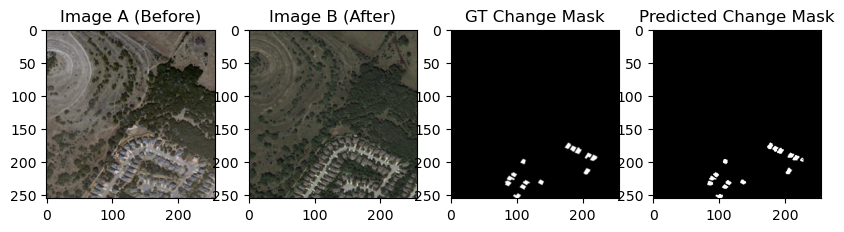

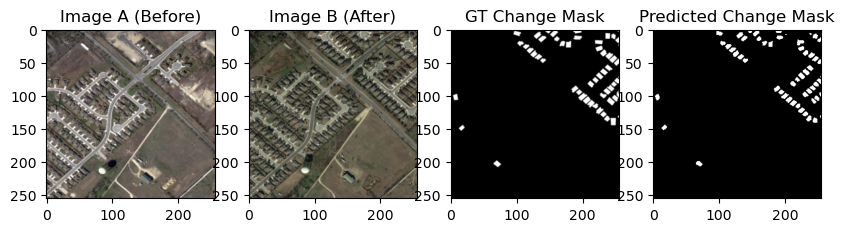

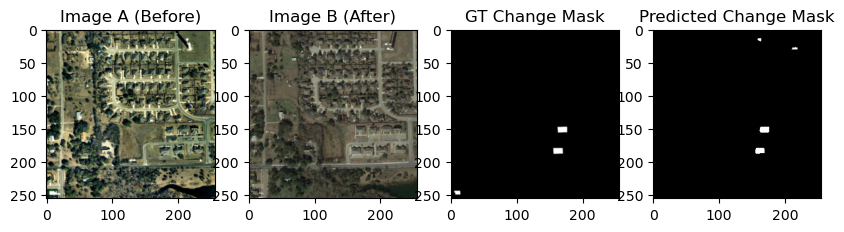

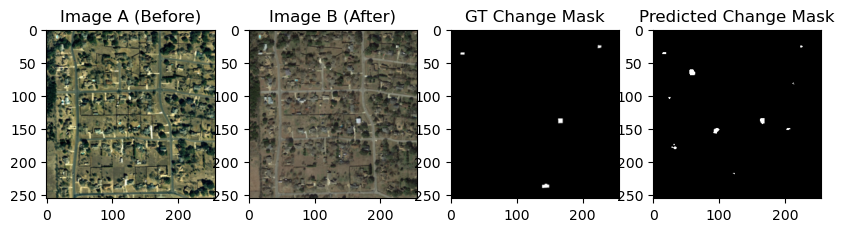

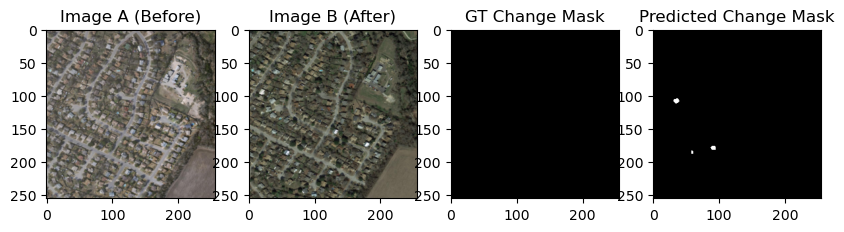

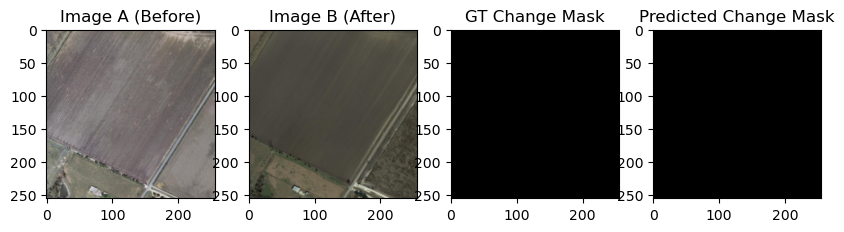

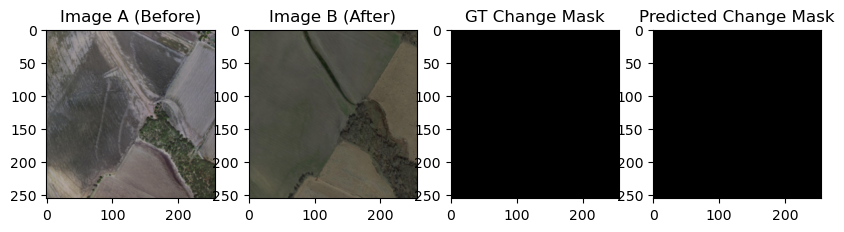

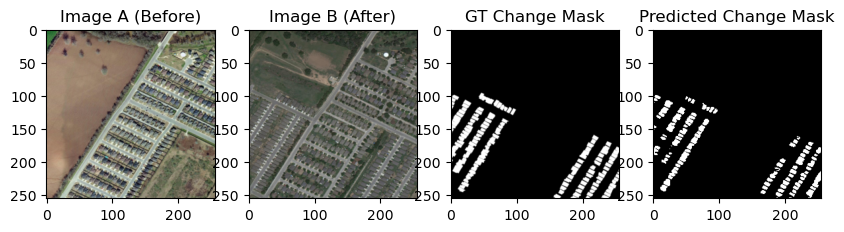

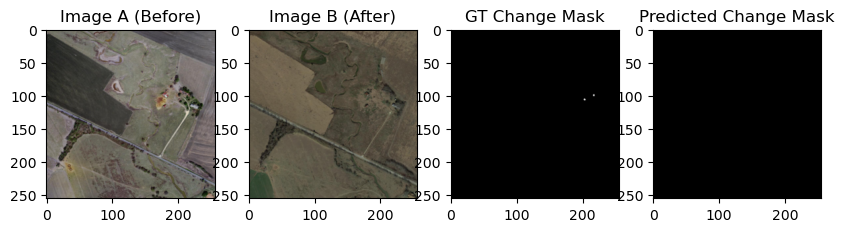

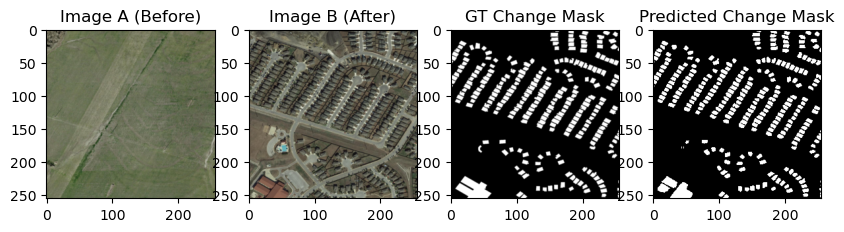

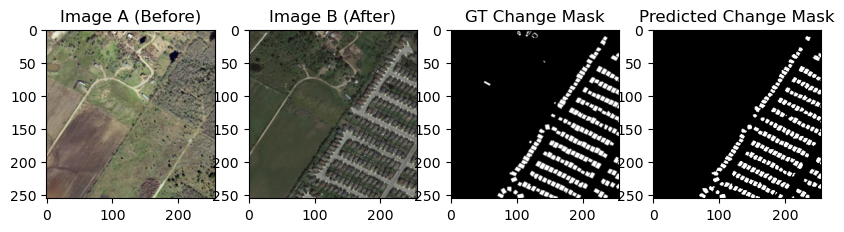

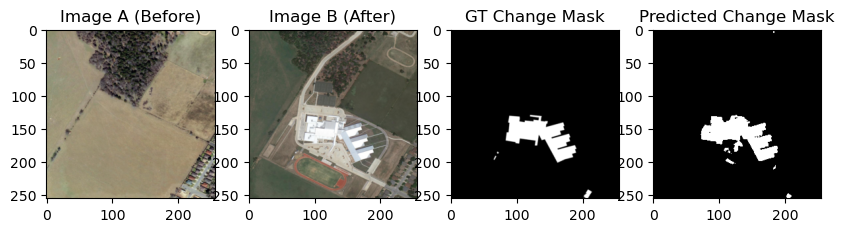

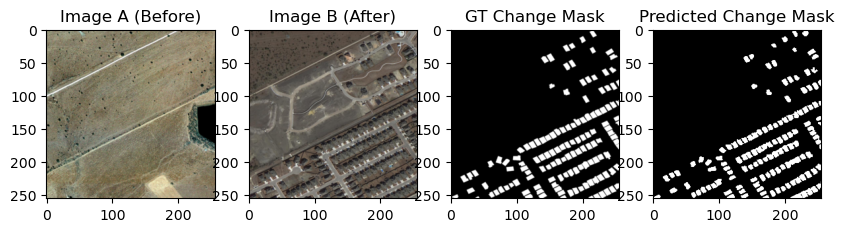

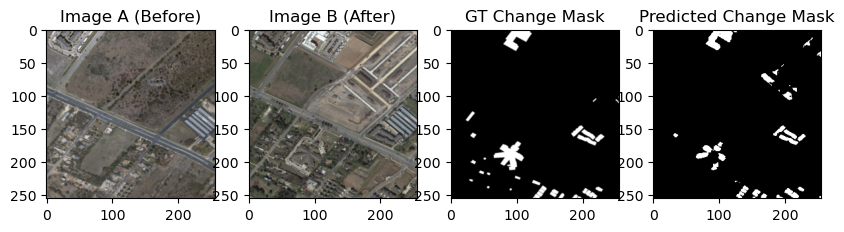

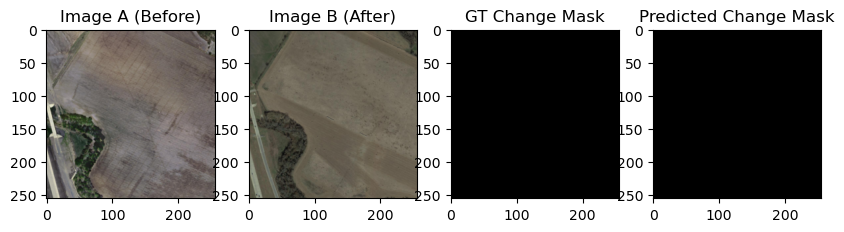

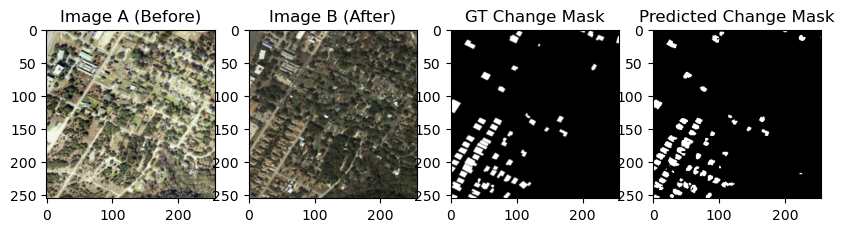

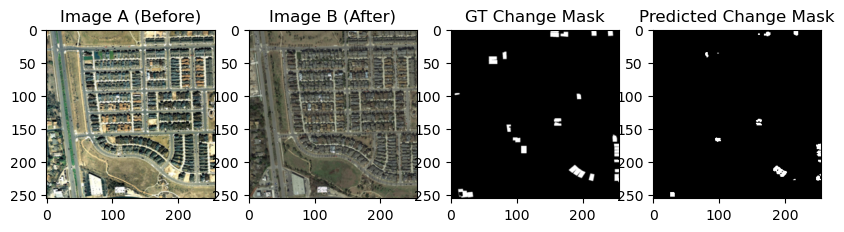

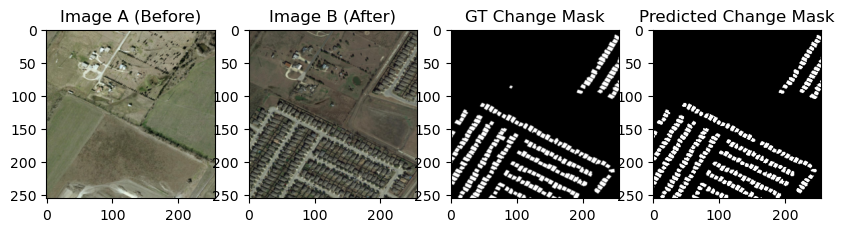

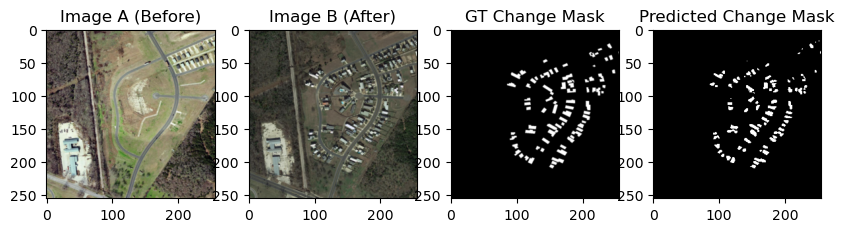

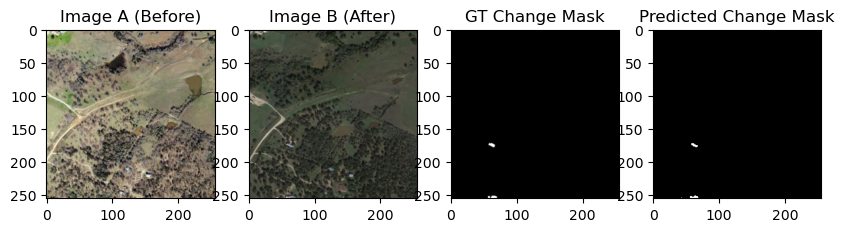

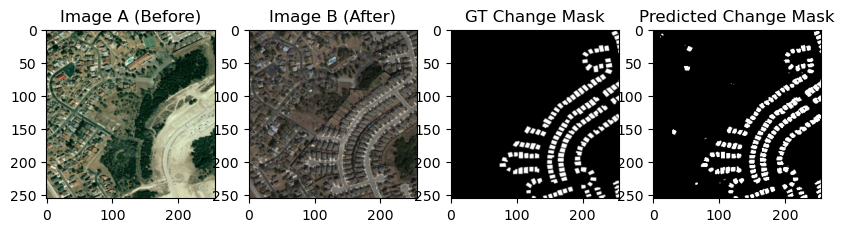

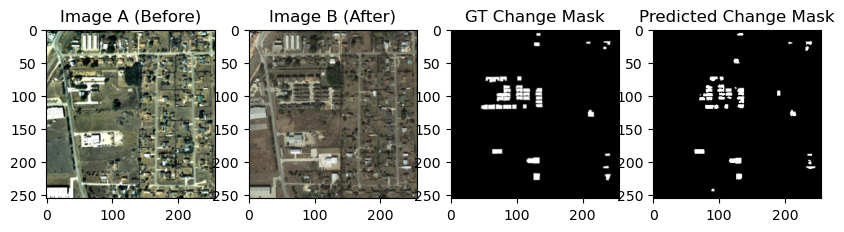

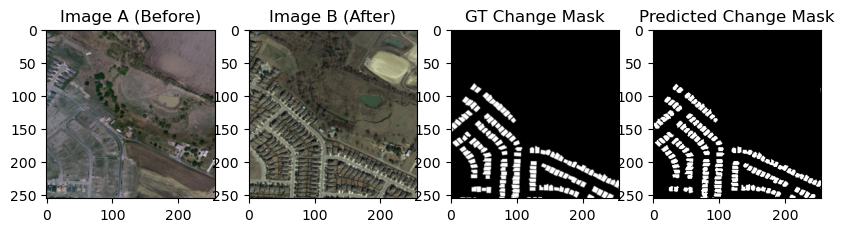

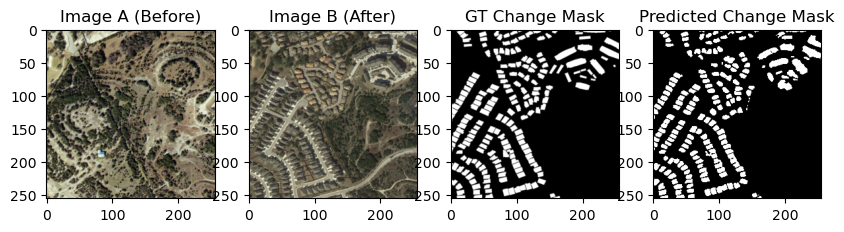

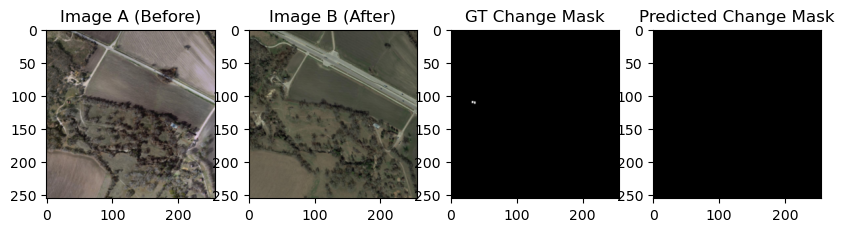

In [38]:
visualize_test_results(model, test_loader, num_examples=5)